# Set up `Observation` objects for each Exfor subentry

Internally, this involves initializing a `jitr.xs.elastic.DifferentialWorkspace` for each `Observation`, which precomputes things like boundary conditions to speed up computation of observables for an interaction parameter.

In [1]:
import numpy as np

In [2]:
import rxmc

Using database version X4-2024-12-31 located in: /mnt/home/beyerkyl/x4db/unpack_exfor-2024/X4-2024-12-31


In [3]:
import lzma
import pickle
from pathlib import Path

from tqdm import tqdm

output_dir = Path("./data/")

In [4]:
with lzma.open(output_dir / "pp_elastic_data.xz", "rb") as f:
    pp_elastic_measurements = pickle.load(f)
with lzma.open(output_dir / "nn_elastic_data.xz", "rb") as f:
    nn_elastic_measurements = pickle.load(f)

In [5]:
nn_observations = {}
for entry_id, mlist in tqdm(nn_elastic_measurements.items()):
    if entry_id not in nn_observations:
        nn_observations[entry_id] = []
    for rxn, m in mlist:
        nn_observations[entry_id].append(
            rxmc.elastic_diffxs_observation.ElasticDifferentialXSObservation(
                measurement=m,
                reaction=rxn,
                quantity="dXS/dA",
                lmax=50,
                angles_vis=np.linspace(
                    max(0, np.min(m.x) * 0.9), min(180, np.max(m.x) * 1.1), 100
                ),
                ObservationClass=rxmc.observation.Observation,
                error_kwargs={
                    "include_sys_norm_err": False,
                    "include_sys_offset_err": False,
                },
            )
        )

100%|██████████| 18/18 [04:26<00:00, 14.81s/it]


In [6]:
pp_observations = {}
for entry_id, mlist in tqdm(pp_elastic_measurements.items()):
    if entry_id not in pp_observations:
        pp_observations[entry_id] = []
    for rxn, m in mlist:
        pp_observations[entry_id].append(
            rxmc.elastic_diffxs_observation.ElasticDifferentialXSObservation(
                m,
                rxn,
                "dXS/dRuth",
                50,
                angles_vis=np.linspace(
                    max(0, np.min(m.x) * 0.9), min(180, np.max(m.x) * 1.1), 100
                ),
                ObservationClass=rxmc.observation.Observation,
                error_kwargs={
                    "include_sys_norm_err": False,
                    "include_sys_offset_err": False,
                },
            )
        )

100%|██████████| 55/55 [10:28<00:00, 11.42s/it]


In [7]:
with lzma.open(output_dir / "pp_elastic_observations.xz", "wb") as f:
    pickle.dump(pp_observations, f)
with lzma.open(output_dir / "nn_elastic_observations.xz", "wb") as f:
    pickle.dump(nn_observations, f)

## Some tests

In [8]:
with open("../likelihood_model/likelihood_model.pkl", "rb") as f:
    lm = pickle.load(f)

In [9]:
from matplotlib import pyplot as plt

In [10]:
pp_observations.keys()

dict_keys(['E0166', 'O0387', 'C0624', 'O0239', 'C0076', 'C0893', 'O0254', 'O0352', 'O0384', 'T0108', 'O0049', 'O0142', 'O0208', 'O0382', 'T0101', 'O0211', 'O0253', 'O0302', 'C2165', 'E1201', 'O0458', 'O0169', 'C0085', 'D0295', 'O0351', 'O0372', 'O0389', 'F0733', 'O0300', 'O0370', 'O0788', 'O1825', 'T0152', 'O0545', 'C0622', 'O0549', 'T0289', 'O0471', 'O0581', 'O0580', 'C2174', 'E2042', 'O0124', 'O0328', 'O2532', 'E0904', 'D0289', 'F1173', 'C0081', 'O0157', 'O0225', 'O0272', 'O0285', 'O0287', 'O0552'])

In [11]:
obs = pp_observations["O0387"][0]

In [12]:
y = 0.9 * obs.y + 0.01

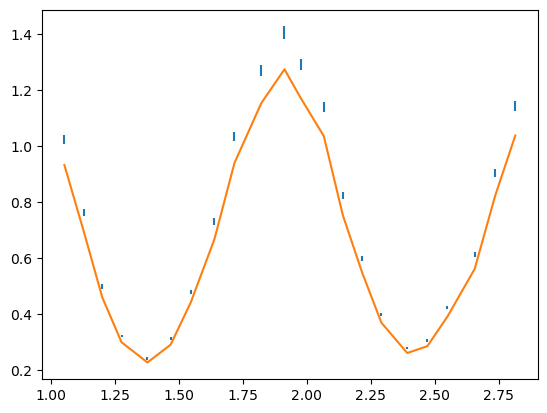

In [13]:
plt.errorbar(
    obs.x,
    obs.y,
    np.diag(np.sqrt(obs._obs.statistical_covariance)),
    linestyle="none",
)
plt.plot(obs.x, y)
# plt.yscale("log")

In [14]:
np.sum((y - obs.y) ** 2 / ((y * 0.3) ** 2 + np.diag(obs._obs.statistical_covariance)))

np.float64(1.96218661253842)

In [15]:
lm.chi2(obs, y)

np.float64(1.9621866125384197)